In [202]:
import pandas as pd
import numpy as np
from functools import reduce
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [3]:
des_data = pd.read_stata(r"C:\Users\timom\OneDrive\Desktop\ML\OHIE_Public_Use_Files\OHIE_Data\oregonhie_descriptive_vars.dta")
ed_data = pd.read_stata(r"C:\Users\timom\OneDrive\Desktop\ML\OHIE_Public_Use_Files\OHIE_Data\oregonhie_ed_vars.dta")
inperson_data = pd.read_stata(r"C:\Users\timom\OneDrive\Desktop\ML\OHIE_Public_Use_Files\OHIE_Data\oregonhie_inperson_vars.dta")
patterns_data = pd.read_stata(r"C:\Users\timom\OneDrive\Desktop\ML\OHIE_Public_Use_Files\OHIE_Data\oregonhie_patterns_vars.dta")
stateprograms_data = pd.read_stata(r"C:\Users\timom\OneDrive\Desktop\ML\OHIE_Public_Use_Files\OHIE_Data\oregonhie_stateprograms_vars.dta")
survey0_data = pd.read_stata(r"C:\Users\timom\OneDrive\Desktop\ML\OHIE_Public_Use_Files\OHIE_Data\oregonhie_survey0m_vars.dta")
survey6_data = pd.read_stata(r"C:\Users\timom\OneDrive\Desktop\ML\OHIE_Public_Use_Files\OHIE_Data\oregonhie_survey6m_vars.dta")
survey12_data = pd.read_stata(r"C:\Users\timom\OneDrive\Desktop\ML\OHIE_Public_Use_Files\OHIE_Data\oregonhie_survey12m_vars.dta")

In [4]:
#Descriptive 
des_data = des_data.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
des_data.replace(-1, np.nan, inplace=True)
des_subdata = des_data[['person_id', 'household_id', 'treatment',
                    'applied_app', 'approved_app', 'postn_death', 'english_list','numhh_list', 
                    'birthyear_list', 'female_list','zip_msa_list']]
des_subdata.loc[:,"numhh_list"] = des_subdata["numhh_list"] + 1


C:\Users\timom\AppData\Local\Temp\ipykernel_22488\1644137401.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  des_subdata.loc[:,"numhh_list"] = des_subdata["numhh_list"] + 1


In [35]:
# State
stateprograms_data = stateprograms_data.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
stateprograms_data.replace(-1, np.nan, inplace=True)

In [6]:
# Education
ed_data = ed_data.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
ed_data.replace(-1, np.nan, inplace=True)


In [7]:
# In Person
inperson_data = inperson_data.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
inperson_data.replace(-1, np.nan, inplace=True)


In [8]:
# Patterns
patterns_data = patterns_data.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
patterns_data.replace(-1, np.nan, inplace=True)


In [9]:
# Survey 0
survey0_data = survey0_data.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
survey0_data.replace(-1, np.nan, inplace=True)


In [10]:
# Survey 6
survey6_data = survey6_data.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
survey6_data.replace(-1, np.nan, inplace=True)


In [11]:
# Survey 12
survey12_data = survey12_data.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
survey12_data.replace(-1, np.nan, inplace=True)


In [13]:
dfs = [des_subdata, stateprograms_data, ed_data, inperson_data, patterns_data, survey0_data, survey6_data, survey12_data]
merged = reduce(lambda left, right: pd.merge(left, right, on='person_id', how='outer'), dfs)

In [14]:
df_filtered = merged.filter(regex='^(?!.*_y$)')
df_filtered = df_filtered.rename(lambda x: x.replace('_x', ''), axis=1)
df_filtered = df_filtered.apply(lambda x: pd.to_numeric(x, errors='coerce') if x.dtype == 'object' else x)
datetime_columns = df_filtered.select_dtypes('datetime64[ns]').columns
ordinal_encoder = OrdinalEncoder()
df_filtered[datetime_columns] = ordinal_encoder.fit_transform(df_filtered[datetime_columns])


In [49]:
outcome1 = ['happiness_12m', 'health_gen_bin_12m', 'health_chg_bin_12m', 
             'baddays_phys_12m', 'baddays_ment_12m', 'health_work_12m', 
             'dep_interest_12m', 'dep_sad_12m'] 

outcome2 = ['cost_any_oop_12m', 'cost_tot_oop_12m', 'cost_any_owe_12m', 
             'cost_tot_owe_12m', 'cost_borrow_12m', 'cost_refused_12m'] 

outcome3 = ['rx_any_12m','rx_any_12m', 'rx_num_mod_12m', 'doc_any_12m', 'doc_num_mod_12m', 
             'er_any_12m', 'er_num_mod_12m', 'hosp_any_12m' , 'hosp_num_mod_12m']

outcomes = outcome1 + outcome2 + outcome3
        
remove = list(survey12_data.columns)

# Boost

## Outcome 1

In [139]:
df = df_filtered.dropna(subset= outcome1)

X1 = df.drop(columns= ['person_id','household_id', 'ohp_all_ever_matchn_30sep2009','birthyear_0m'] + outcomes + remove)  

y1 = df[outcome1]

In [140]:
model1 = xgb.XGBRegressor(objective='reg:squarederror')
model1.fit(X1, y1)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

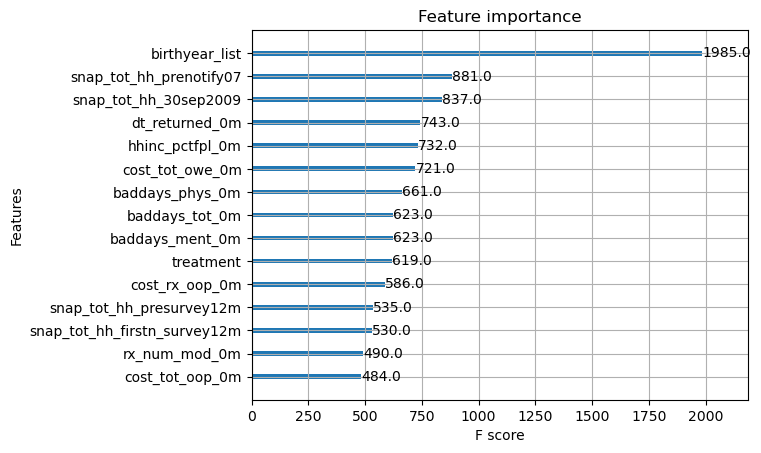

In [141]:
xgb.plot_importance(model1,max_num_features=15)

## Outcome 2

In [142]:
df = df_filtered.dropna(subset= outcome2)

X2 = df.drop(columns= ['person_id','household_id', 'ohp_all_ever_matchn_30sep2009', 'birthyear_0m'] + outcomes + remove)  

y2 = df[outcome2]


In [143]:
model2 = xgb.XGBRegressor(objective='reg:squarederror')
model2.fit(X2, y2)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

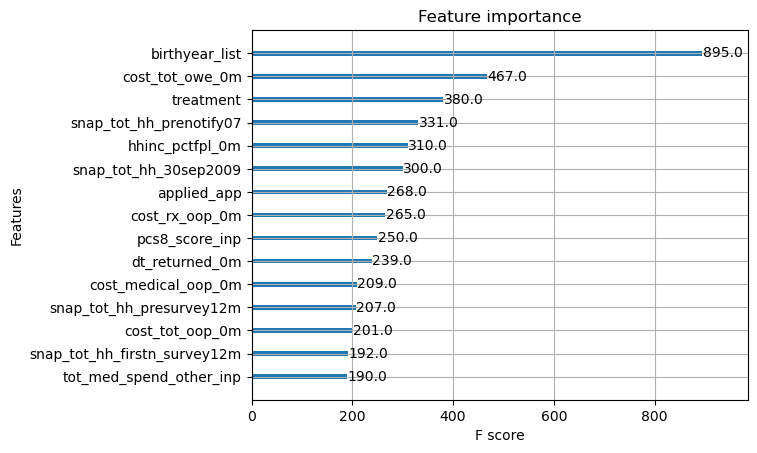

In [144]:
xgb.plot_importance(model2,max_num_features=15)

## Outcome 3

In [145]:
df = df_filtered.dropna(subset= outcome3)

X3 = df.drop(columns= ['person_id','household_id', 'ohp_all_ever_matchn_30sep2009', 'birthyear_0m'] + outcomes + remove)  

y3 = df[outcome3]


In [146]:
model3 = xgb.XGBRegressor(objective='reg:squarederror')
model3.fit(X3, y3)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

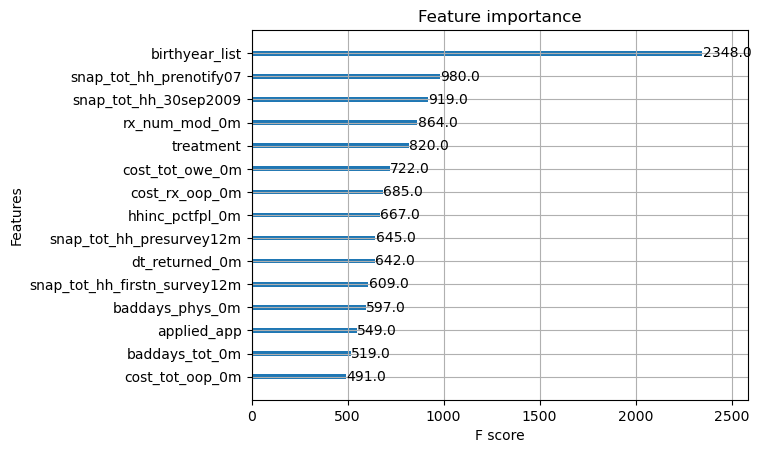

In [147]:
xgb.plot_importance(model3,max_num_features=15)

In [148]:
n = 100

thresh = 300

importances = model1.get_booster().get_score(importance_type='weight')
sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)

top1n = [feature for feature, x in sorted_importances[:n] if x > thresh]
top1 = [X.columns.get_loc(feature) for feature in top1n]
        
importances = model2.get_booster().get_score(importance_type='weight')
sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)

top2n = [feature for feature, x in sorted_importances[:n] if x > thresh]
top2 = [X.columns.get_loc(feature) for feature in top2n]


importances = model2.get_booster().get_score(importance_type='weight')
sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)

top3n = [feature for feature, x in sorted_importances[:n] if x > thresh]
top3 = [X.columns.get_loc(feature) for feature in top3n]


In [149]:
top_feat = np.unique(top1n + top2n + top3n)
top_feat = [str(x) for x in top_feat]
top_feat



['applied_app',
 'baddays_ment_0m',
 'baddays_phys_0m',
 'baddays_tot_0m',
 'birthyear_list',
 'bmi_inp',
 'cost_medical_oop_0m',
 'cost_rx_oop_0m',
 'cost_tot_oop_0m',
 'cost_tot_oop_correct_0m',
 'cost_tot_owe_0m',
 'doc_num_mod_0m',
 'dt_returned_0m',
 'hdl_inp',
 'health_gen_0m',
 'hhinc_cat_0m',
 'hhinc_pctfpl_0m',
 'hhsize_0m',
 'living_arrange_0m',
 'mcs8_score_inp',
 'numhh_list',
 'pcs8_score_inp',
 'phqtot_inp',
 'rx_num_mod_0m',
 'snap_tot_hh_30sep2009',
 'snap_tot_hh_firstn_survey12m',
 'snap_tot_hh_prenotify07',
 'snap_tot_hh_presurvey12m',
 'treatment',
 'usual_care_0m',
 'wave_survey0m',
 'weight_total_inp']

In [153]:
df = df_filtered[['person_id','household_id', 'ohp_all_ever_matchn_30sep2009','sample_12m_resp'] + outcomes + top_feat]

In [160]:
sample = df[df['sample_12m_resp'] == 1].drop(columns = 'sample_12m_resp')

In [167]:
sample.describe()

,person_id,household_id,ohp_all_ever_matchn_30sep2009,happiness_12m,health_gen_bin_12m,health_chg_bin_12m,baddays_phys_12m,baddays_ment_12m,health_work_12m,dep_interest_12m,...,phqtot_inp,rx_num_mod_0m,snap_tot_hh_30sep2009,snap_tot_hh_firstn_survey12m,snap_tot_hh_prenotify07,snap_tot_hh_presurvey12m,treatment,usual_care_0m,wave_survey0m,weight_total_inp
count,23741.000000,23741.000000,23741.000000,23416.000000,23361.000000,23407.000000,21384.00000,21601.000000,23324.000000,23326.000000,...,5721.000000,15317.000000,23741.000000,23741.000000,23741.000000,23741.000000,23741.000000,10473.000000,23741.000000,7939.000000
mean,37296.851562,140986.390625,0.276821,1.263495,0.430504,0.270047,9.50463,11.027267,0.400575,1.016677,...,6.801608,1.693543,1927.297713,2244.720568,1438.238785,1120.815930,0.497367,1.631529,3.438482,0.984675
std,21612.953125,21296.521484,0.447437,0.658531,0.495157,0.443994,10.85554,11.266710,0.490025,1.049320,...,5.898790,2.550425,2329.711310,2648.194507,1890.788329,1539.088475,0.500004,1.846193,2.076460,0.850123
min,1.000000,100001.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18525.000000,123327.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.895068
50%,37230.000000,142872.000000,0.000000,1.000000,0.000000,0.000000,5.00000,7.000000,0.000000,1.000000,...,5.000000,0.000000,1253.000000,1532.000000,700.000000,324.000000,0.000000,1.000000,4.000000,1.000000
75%,56005.000000,159404.000000,1.000000,2.000000,1.000000,1.000000,15.00000,20.000000,1.000000,2.000000,...,10.000000,3.000000,2988.000000,3390.000000,2367.000000,1983.000000,1.000000,3.000000,5.000000,1.159381
max,74921.000000,174921.000000,1.000000,2.000000,1.000000,1.000000,30.00000,30.000000,1.000000,3.000000,...,24.000000,23.000000,19351.000000,24374.000000,20745.000000,15190.000000,1.000000,6.000000,7.000000,13.266743


In [163]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23741 entries, 0 to 74920
Data columns (total 58 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   person_id                      23741 non-null  float32
 1   household_id                   23741 non-null  float32
 2   ohp_all_ever_matchn_30sep2009  23741 non-null  int8   
 3   happiness_12m                  23416 non-null  float64
 4   health_gen_bin_12m             23361 non-null  float64
 5   health_chg_bin_12m             23407 non-null  float64
 6   baddays_phys_12m               21384 non-null  float64
 7   baddays_ment_12m               21601 non-null  float64
 8   health_work_12m                23324 non-null  float64
 9   dep_interest_12m               23326 non-null  float64
 10  dep_sad_12m                    23371 non-null  float64
 11  cost_any_oop_12m               23426 non-null  float64
 12  cost_tot_oop_12m               22731 non-null 

In [174]:
# sample.to_csv('sample.csv', index = False)

## Looking for HTE

In [188]:
trial = sample.groupby(top_feat)
trial = trial[outcomes].agg('mean')
trial

happiness_12m  \
applied_app baddays_ment_0m baddays_phys_0m baddays_tot_0m birthyear_list bmi_inp   cost_medical_oop_0m cost_rx_oop_0m cost_tot_oop_0m cost_tot_oop_correct_0m cost_tot_owe_0m doc_num_mod_0m dt_returned_0m hdl_inp   health_gen_0m hhinc_cat_0m hhinc_pctfpl_0m hhsize_0m living_arrange_0m mcs8_score_inp numhh_list pcs8_score_inp phqtot_inp rx_num_mod_0m snap_tot_hh_30sep2009 snap_tot_hh_firstn_survey12m snap_tot_hh_prenotify07 snap_tot_hh_presurvey12m treatment usual_care_0m wave_survey0m weight_total_inp                  
0.0         0.0             0.0             0.0            1948           35.202942 0.0                 21.0           21.0            126.0                   0.0             0.0            38.0           55.830002 2.0           10.0         163.006180      2.0       1.0               47.618229      2          27.038519      12.0       2.0           0                     0.0                          0                       0.0                      1         0.0           4.0           1.000000                    1.0   
                                                           1949           25.749838 300.0               30.0           330.0           480.0                   500.0           0.0            72.0           86.580002 2.0           4.0          80.794090       1.0       0.0               60.162128      1          52.406010      0.0        3.0           1359                  1479.0                       488                     368.0                    1         3.0           5.0           1.003278                    1.0   
                                                                          28.395338 550.0               10.0           560.0           610.0                   0.0             2.0            61.0           45.330002 3.0           17.0         283.115997      2.0       1.0               52.494026      2          56.258911      0.0        1.0           0                     0.0                          0                       0.0                      1         0.0           3.0           1.201815                    0.0   
                                                           1952           27.275448 300.0               0.0            300.0           300.0                   0.0             0.0            101.0          76.830002 4.0           8.0          102.403061      3.0       1.0               57.480347      2          56.676060      1.0        0.0           0                     0.0                          0                       0.0                      1         0.0           3.0           0.897460                    1.0   
                                                           1953           27.153555 113.0               45.0           158.0           383.0                   0.0             1.0            51.0           56.580002 2.0           0.0          0.000000        1.0       0.0               57.666363      1          54.156078      4.0        2.0           0                     0.0                          0                       0.0                      1         0.0           4.0           1.003278                    1.0   
...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   ...   
1.0         30.0            30.0            30.0           1963           32.303753 0.0                 30.0           30.0            180.0                   500.0           1.0            26.0           66.330002 0.0           0.0          0.000000        2.0       5.0               36.223583      1      

In [186]:
# trial.reset_index().to_csv('trial.csv', index = False)

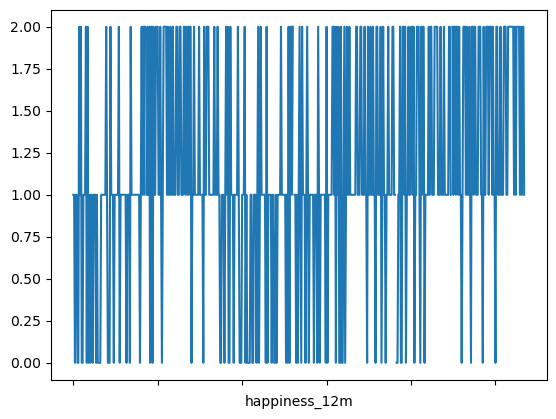

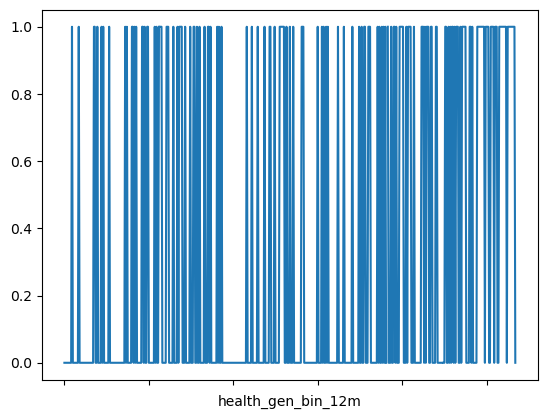

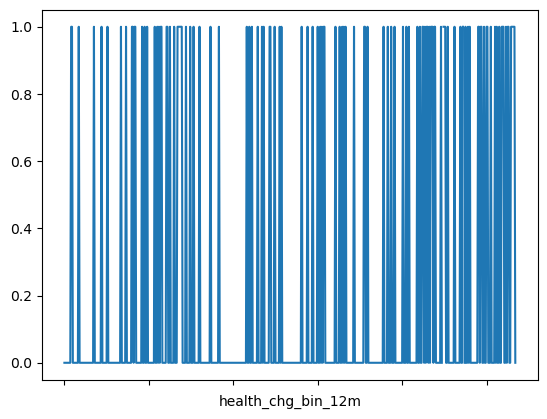

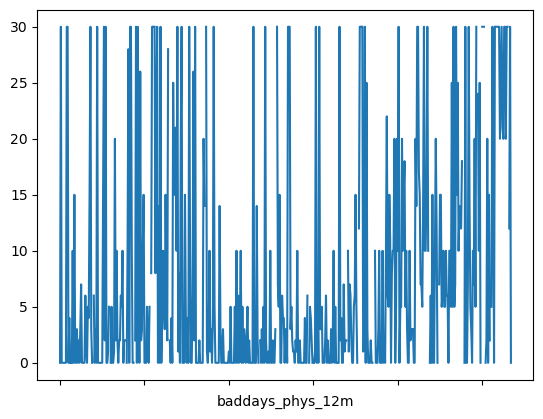

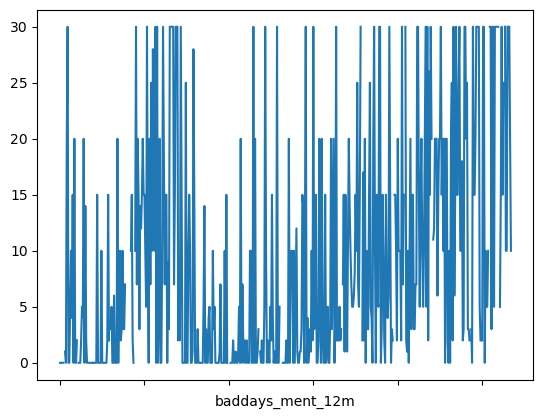

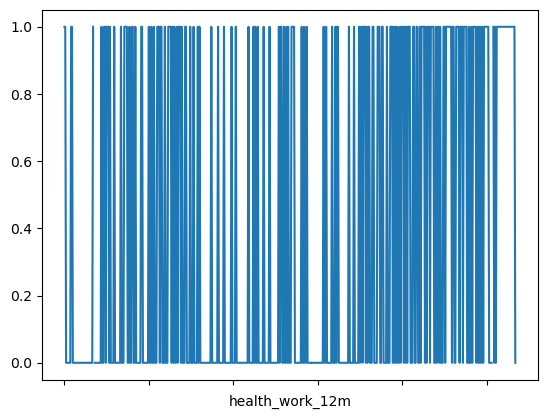

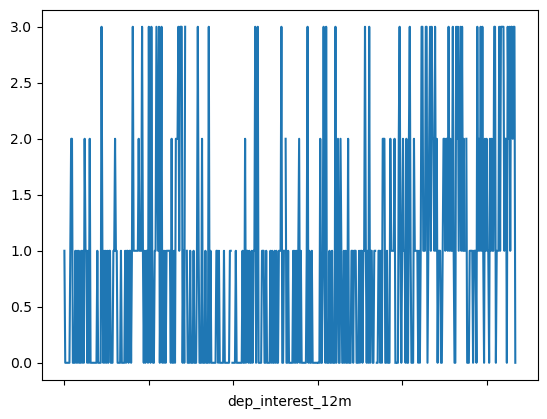

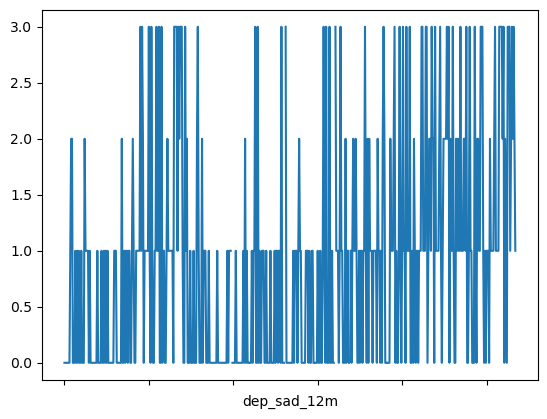

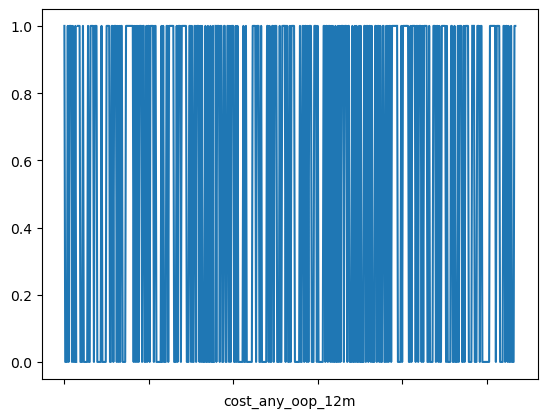

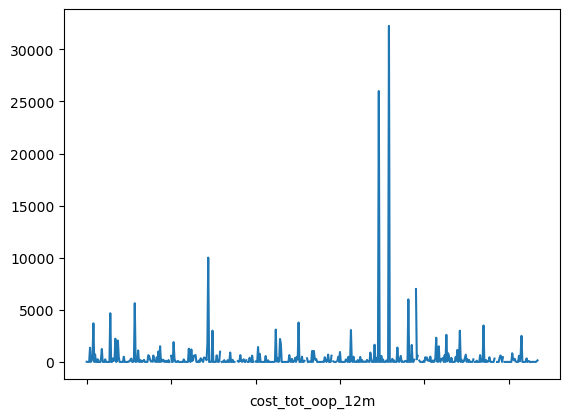

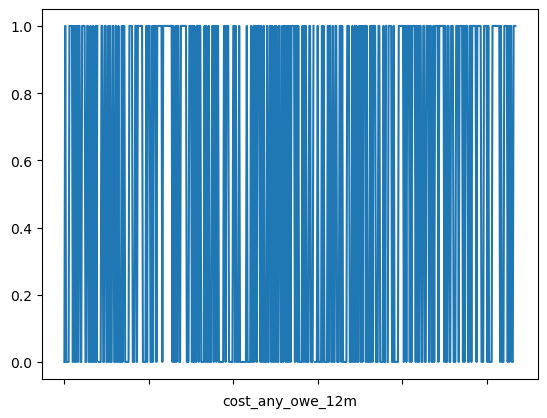

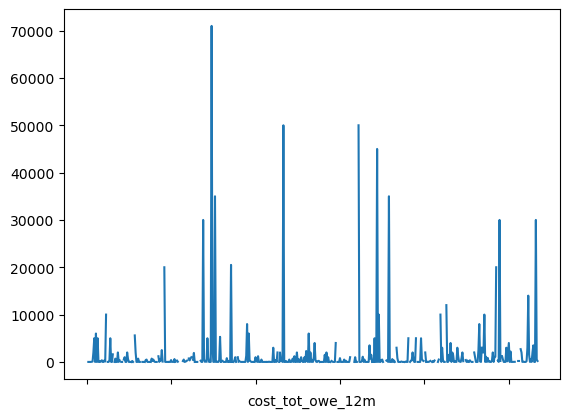

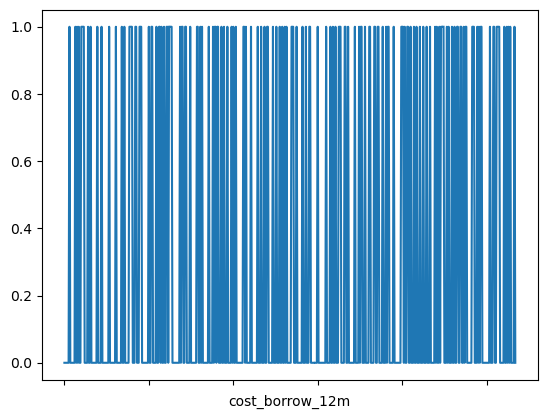

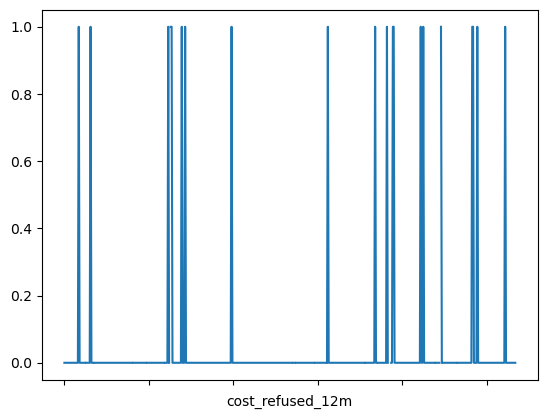

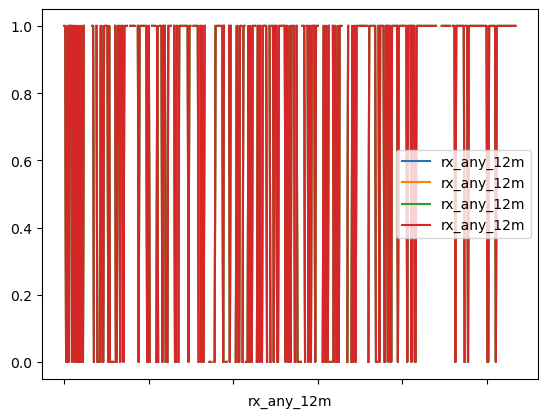

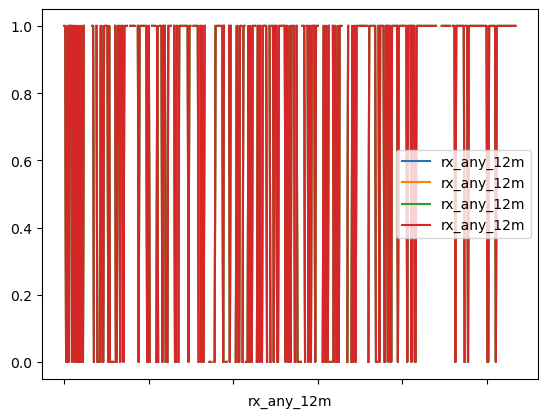

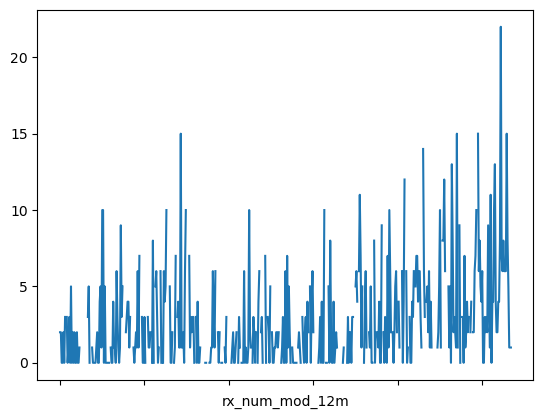

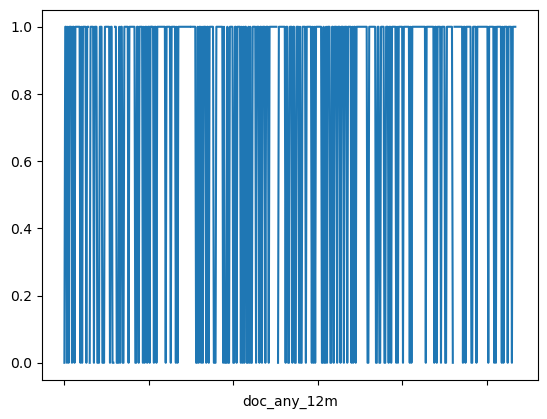

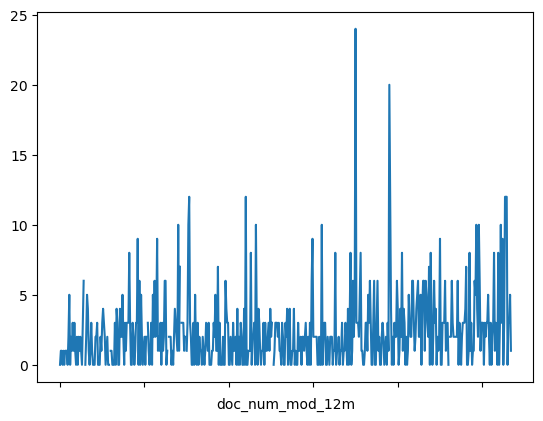

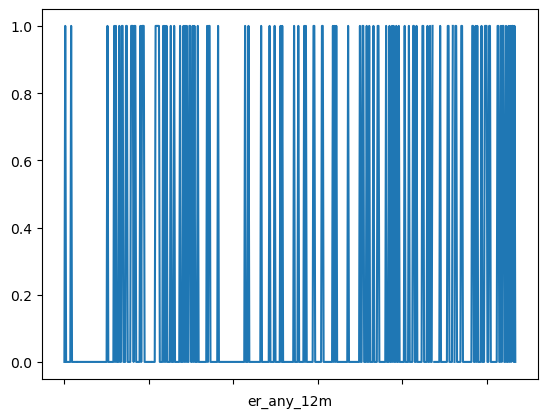

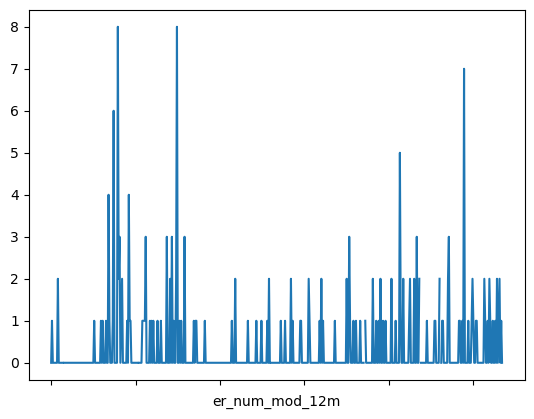

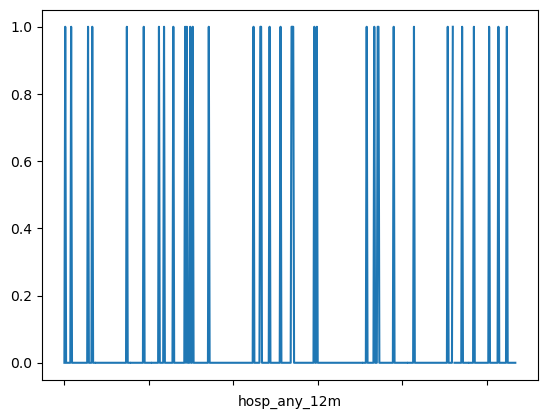

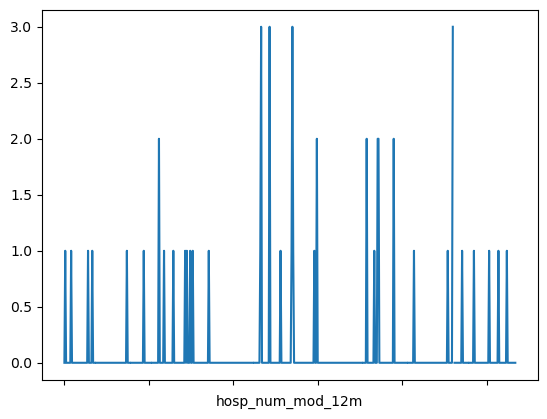

In [211]:
for name in outcomes:
    ax = trial[name].plot()

    ax.set_xticklabels([])

    ax.set_xlabel(str(name))

    plt.show()
